# Notebook to show results

Import libraries needed

In [388]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.patches as mpatches

In [ ]:
from modules.config import (RESULTS_DIR,
                            RESULTS_FILE, 
                            GRAPH_DIR,
                            )

SPACE = ' '
SHOW_COUNTS = False # Show how much many relevant datapoints have been read?
CMAP = 'Set3'
CMAP_HEATMAP = 'cividis'

## Define standard function modules

In [390]:
def read_data():
    """read data from csv file into pandas dataframe"""
    results_path = Path(RESULTS_DIR).joinpath(RESULTS_FILE)
    df = pd.read_csv(results_path)
    return df

In [391]:
def filter_results_general(df):
    """based on standard parameters"""    
    df = df[(df['formulation'] == 'original')]
    df = df[(df['hot_start'] == False)]
    df = df[(df['gray'] == False)]
    df = df[(df['iterations'] == 250)]
    return df

Filter out records for analysis

In [392]:
def filter_results_qml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == True)]
    df = filter_results_general(df)
    df = df[(df['gradient_type'] == 'SPSA')]
    df = df[(df['alpha'] == 0.602)]
    df = df[(df['big_a'] == 25)]
    df = df[(df['c'] == 0.314)]
    df = df[(df['gamma'] == 0.101)]
    df = df[(df['eta'] == 0.1)]
    df = df[(df['s'] == 0.5)]
    df = df[(df['shots'] == 1024)]
    return df

In [393]:
def filter_results_ml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == False)]
    df = filter_results_general(df)
    df = df[(df['shots'] == 64)]
    df = df[(df['std_dev'] == 0.05)]
    df = df[(df['lr'] == 2e-5)]
    df = df[(df['weight_decay'] == 0.0006)]
    df = df[(df['momentum'] == 0.8)]
    return df

In [394]:
def find_quality(df, factor=1):
    df['quality'] =  factor* df['best_dist'] / df['best_dist_found'] 
    df['error'] = 1 * factor - df['quality']
    return df

In [395]:
def select_key_fields_qml(df):
    df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode',]]
    return df

In [396]:
def select_key_fields_ml(df):
    df = df[['locations', 'iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'layers', 'elapsed']]
    return df

## Analysis of slicing

In [397]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['mode'] == 2)]
df = df[(df['locations'] > 8)]
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
169,10,1.0,2,290.2,290.2,1.000000,0.000000,2
179,10,1.0,73,290.2,290.2,1.000000,0.000000,2
192,10,1.0,116,290.2,290.2,1.000000,0.000000,2
204,10,1.0,12,290.3,290.2,0.999656,0.000344,2
671,9,1.0,181,286.7,286.7,1.000000,0.000000,2


In [398]:
if SHOW_COUNTS:
    slice_count = df.groupby(['locations', 'slice']).count()
    slice_count.head()
    slice_count_pivot = slice_count.pivot_table(index='locations', columns='slice', values='quality')
    slice_count_pivot

In [399]:
grouped = df.groupby(['locations', 'slice'])
sliced_summary = grouped['error'].agg(
    mean='mean',
    sem='sem'
).reset_index()
sliced_summary = sliced_summary.rename(columns={'mean': 'error'})
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,2.467162e-17,2.467162e-17
1,9,0.2,4.934325e-17,3.263749e-17
2,9,0.3,2.320455e-04,2.320455e-04
3,9,0.4,3.284963e-03,3.032663e-03
4,9,0.5,8.944480e-03,8.944480e-03


In [400]:
def plot_3d_graph_models(grouped_means, input, input2 = 'layers'):
    """plot a 3D bar graph of the given input data grouped by layers and locations""" 
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    input2_vals = sorted(grouped_means[input2].unique())
    locations = sorted(grouped_means['locations'].unique(), reverse=True)

    input2_map = {sli: i for i, sli in enumerate(input2_vals)}
    loc_map = {loc: i for i, loc in enumerate(locations)}
    
    # Assign colors for each location
    #colors = plt.get_cmap('Set3', len(input2_vals))  # or 'Set3', 'Paired', etc.
    colors = plt.get_cmap(CMAP, len(input2_vals))  # or 'Set3', 'Paired', etc.
    input2_colors = {item: colors(i) for i, item in enumerate(input2_vals)}

    # Bar sizes
    dx = 0.5
    dy = 0.15

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = loc_map[row['locations']] - dx/2    # Center the bar on the x-axis
        y = input2_map[row[input2]] - dy/2  # Center the bar on the y-axis
        z = 0
        dz = row[input]

        color = input2_colors[row[input2]]
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True)

    # Label axes
    ax.set_xlabel('Locations')
    ax.set_ylabel(input2)
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(loc_map.values()))
    ax.set_xticklabels(list(loc_map.keys()))
    ax.set_yticks(list(input2_map.values()))
    ax.set_yticklabels(list(input2_map.keys()))

    legend_handles = [mpatches.Patch(color=input2_colors[layer], label=layer) for layer in input2_vals]

    plt.legend(handles=legend_handles, title=input2, loc='upper left', bbox_to_anchor=(1, 1))

    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

    formatted_input = input.replace('_', SPACE).lower()
    title = f'3D bar graph of {formatted_input} by {input2} and locations'
    plt.title(title)
    filepath = Path(GRAPH_DIR).joinpath(title)
    plt.savefig(filepath)
    plt.show()

In [401]:
def plot_3d_graph_slice(grouped_means, input, show_sem=False):
    """plot a 3D bar graph of the given input data grouped by locations and slice."""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Map categorical data to numeric positions
    locations = grouped_means['locations'].unique()
    slices = sorted(grouped_means['slice'].unique())

    loc_map = {loc: i for i, loc in enumerate(locations)}
    slice_map = {sli: i for i, sli in enumerate(slices)}

    # Assign colors for each location
    #colors = plt.get_cmap('Set3', len(locations))  # or 'Set3', 'Paired', etc.
    colors = plt.get_cmap(CMAP, len(locations))  # or 'Set3', 'Paired', etc.
    location_colors = {loc: colors(i) for i, loc in enumerate(locations)}

    # Bar and cap width sizes
    dx = 0.5
    dy = 0.25
    cap_width = 0.1

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = slice_map[row['slice']]   
        y = loc_map[row['locations']]
        x_bar = slice_map[row['slice']] - dx/2    # Center the bar on the x-axis
        y_bar = loc_map[row['locations']] - dy/2  # Center the bar on the y-axis
        z_bar = 0
        dz = row[input]
        if show_sem:
            error = row['sem']

        color = location_colors[row['locations']]
        ax.bar3d(x_bar , y_bar, z_bar, dx, dy, dz, color=color, shade=True)
        
        x_center = x + dx / 4
        y_center = y + dy / 4
        y_center = y

        if show_sem:
            if error > 0:
                #error bars
                ax.plot(
                    [x_center , x_center],
                    [y_center, y_center],
                    [0, dz + error],
                    color='black',
                    linewidth=2
                    )     
                # Horizontal cap at the top
                ax.plot(
                    [x_center - cap_width, x_center + cap_width],
                    [y_center, y_center],
                    [dz + error, dz + error],
                    color='black',
                    linewidth=2
                    )
    # Label axes
    ax.set_xlabel('Slice')
    ax.set_ylabel('Locations')
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(slice_map.values()))
    ax.set_xticklabels(list(slice_map.keys()))
    ax.set_yticks(list(loc_map.values()))
    ax.set_yticklabels(list(loc_map.keys()))

    legend_handles = [mpatches.Patch(color=location_colors[loc], label=loc) for loc in locations]
    plt.legend(handles=legend_handles, title='Locations', loc='upper left', bbox_to_anchor=(1, 1))

    formatted_input = input.replace('_', SPACE).lower()
    title = f'3D bar graph of {formatted_input} by location and slice'
    plt.title(title)
    filepath = Path(GRAPH_DIR).joinpath(title)
    plt.savefig(filepath)
    plt.show()

In [402]:
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,2.467162e-17,2.467162e-17
1,9,0.2,4.934325e-17,3.263749e-17
2,9,0.3,2.320455e-04,2.320455e-04
3,9,0.4,3.284963e-03,3.032663e-03
4,9,0.5,8.944480e-03,8.944480e-03


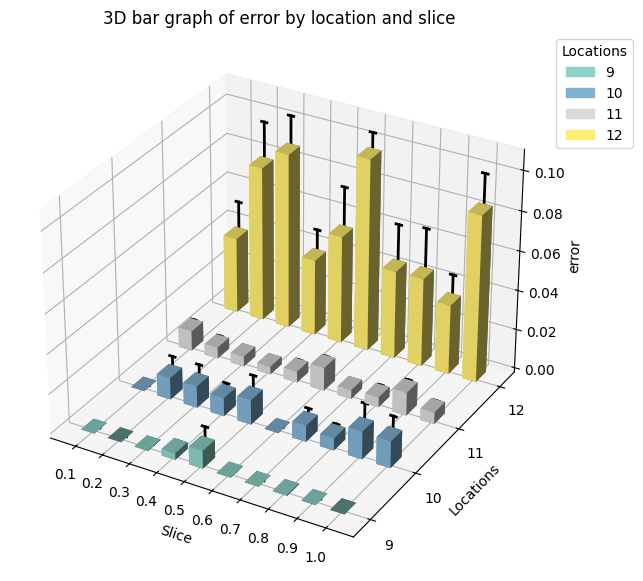

In [403]:
input = 'error'
plot_3d_graph_slice(sliced_summary, input, show_sem=True)

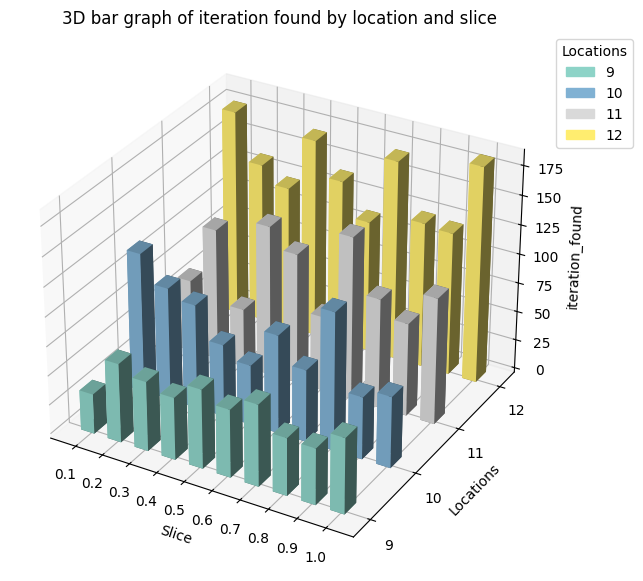

In [404]:
sliced_summary = grouped['iteration_found'].agg(
    mean='mean',
    sem='sem'
).reset_index()

sliced_summary = sliced_summary.rename(columns={'mean': 'iteration_found'})
sliced_summary.head()

input = 'iteration_found'
plot_3d_graph_slice(sliced_summary, input, show_sem=False)

## Analysis of qml models

In [405]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['slice'] == 1.0)]

In [406]:
mode_summary = df.groupby(['mode', 'locations']).mean().reset_index()
mode_summary.head()

,mode,locations,slice,iteration_found,best_dist_found,best_dist,quality,error
0,1,4,1.0,0.0,21.0,21.0,1.0,0.0
1,1,5,1.0,0.0,19.0,19.0,1.0,0.0
2,1,6,1.0,5.0,241.0,241.0,1.0,0.0
3,1,7,1.0,0.0,276.2,276.2,1.0,0.0
4,1,8,1.0,2.5,277.2,277.2,1.0,0.0


## Analysis of ml models with different numbers of layers

In [407]:
df = read_data()
df = filter_results_ml(df)
df = find_quality(df)
df = select_key_fields_ml(df)
df = df[(df['mode'] == 8)]
df['layers'] = df['layers'].astype(int)

In [408]:
df.head()

,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,layers,elapsed
573,10,6,447.100006,290.2,0.649072,0.350928,8,2,202.633927
591,10,9,328.700012,290.2,0.882872,0.117128,8,2,208.004263
610,10,26,356.700012,290.2,0.813569,0.186431,8,1,215.333851
611,10,4,424.500000,290.2,0.683628,0.316372,8,2,222.882087
612,10,5,422.700012,290.2,0.686539,0.313461,8,2,200.864060


In [409]:
layers_summary = df.groupby(['layers','locations', ]).mean().reset_index()
layers_summary.head()

,layers,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,elapsed
0,1,4,0.0,21.000000,21.0,1.000000,0.000000,8.0,36.065529
1,1,5,0.0,19.000000,19.0,1.000000,0.000000,8.0,51.213325
2,1,6,0.0,256.299988,241.0,0.940304,0.059696,8.0,77.375575
3,1,7,2.0,308.000000,276.2,0.896753,0.103247,8.0,118.169566
4,1,8,51.0,277.700012,277.2,0.998199,0.001801,8.0,146.837071


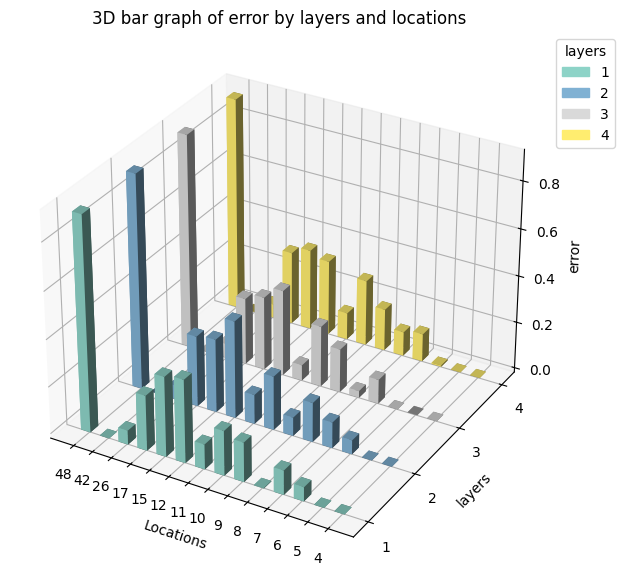

In [410]:
input = 'error'
plot_3d_graph_models(layers_summary, input)

In [411]:
layers_means = df.groupby(['locations', 'layers',]).mean().reset_index()

In [412]:
ml_means = layers_means.groupby(['layers',]).mean().reset_index()
ml_means.head()

,layers,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,elapsed
0,1,15.714286,28.202381,8708.421429,1185.821429,0.820098,0.179902,8.0,609.542481
1,2,15.714286,39.928571,8823.215476,1185.821429,0.802947,0.197053,8.0,589.913110
2,3,15.714286,30.000000,9039.450001,1185.821429,0.816347,0.183653,8.0,637.501351
3,4,15.714286,43.661905,8598.325000,1185.821429,0.804412,0.195588,8.0,619.802074


# Impact of hot start

### QML - hot start

In [413]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]


df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [414]:
hot_qml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [415]:
pivot = hot_qml_mean.pivot_table(index='locations', columns='hot_start', values='quality')
pivot = pivot.round(1)
print(pivot)

hot_start  False  True 
locations              
4          100.0  100.0
5          100.0  100.0
6          100.0  100.0
7          100.0  100.0
8          100.0  100.0
9          100.0  100.0
10          99.4   98.9
11          99.5  100.0
12          95.5   93.3


In [416]:
hot_summary = hot_qml_mean.groupby(['hot_start',]).mean().reset_index()
hot_summary.head()

,hot_start,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,8.0,0.8,43.632804,219.934709,217.944444,99.373572,0.626428,2.0
1,True,8.0,0.8,75.488889,220.664444,217.944444,99.137975,0.862025,2.0


### Classical ML - hot start

In [417]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [418]:
hot_ml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [419]:
pivot = hot_ml_mean.pivot_table(index='locations', columns='hot_start', values='quality')
pivot = pivot.round(1)
print(pivot)

hot_start  False  True 
locations              
4          100.0  100.0
5          100.0  100.0
6           98.3   88.7
7           88.6  100.0
8           90.9   94.6
9           83.3  100.0
10          77.8   91.7
11          89.1   93.0
12          66.2   78.8
15          66.4   70.4
17          70.2   70.7
26          94.1   78.0
42         100.0   77.7
48           9.3    9.4


In [420]:
hot_ml_summary = hot_ml_mean.groupby(['hot_start',]).mean().reset_index()
hot_ml_summary.head()

,hot_start,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,15.714286,1.0,40.174603,8694.728300,1185.821429,81.014103,18.985897,8.011278
1,True,15.714286,1.0,44.311224,8664.162758,1185.821429,82.342026,17.657974,8.020408


## Impact of Gray encoding

### QML - Gray

In [421]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'gray']]

gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
if SHOW_COUNTS:
    gray_mean_qml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
gray_qml_pivot = gray_mean_qml.pivot_table(index='locations', columns='gray', values='quality')
gray_qml_pivot = gray_qml_pivot.round(1)
print(gray_qml_pivot)


gray       False  True 
locations              
4          100.0  100.0
5          100.0  100.0
6          100.0  100.0
7          100.0  100.0
8          100.0  100.0
9          100.0   99.4
10          99.4   98.5
11          99.5   98.8
12          95.5   96.7


In [422]:

gray_summary_qml = gray_mean_qml.groupby(['gray',]).mean().reset_index()
gray_summary_qml.head(20)

,gray,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,8.0,0.8,43.632804,219.934709,217.944444,99.373572,0.626428,2.0
1,True,8.0,0.8,36.762610,220.109383,217.944444,99.272969,0.727031,2.0


### Classical ML - Gray

In [423]:

df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    gray_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

In [424]:
gray_ml_pivot = gray_mean_ml.pivot_table(index='locations', columns='gray', values='quality')
gray_ml_pivot = gray_ml_pivot.round(2)
print(gray_ml_pivot)

gray        False   True 
locations                
4          100.00  100.00
5          100.00   98.10
6           99.45  100.00
7           88.16   98.85
8           89.70   80.60
9           82.14   78.42
10          72.03   71.96
11          88.53   89.29
12          68.12   70.45
15          65.61   67.11
17          68.94   71.94
26          94.08   93.47
42         100.00  100.00
48           9.43    9.60


In [425]:
gray_summary_ml = gray_mean_ml.groupby(['gray',]).mean().reset_index()
gray_summary_ml.head(20)

,gray,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,15.714286,1.0,43.661905,8598.32500,1185.821429,80.441208,19.558792,8.0
1,True,15.714286,1.0,46.493651,8446.50397,1185.821429,80.700148,19.299852,8.0


## Impact of formalation

### QML - formulation

In [426]:
df = read_data()
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'formulation',]]

form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
if SHOW_COUNTS:
    form_mean_qml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
form_qml_pivot = form_mean_qml.pivot_table(index='locations', columns='formulation', values='quality')
form_qml_pivot = form_qml_pivot.round(1)
print(form_qml_pivot)


formulation    new  original
locations                   
4            100.0     100.0
5            100.0     100.0
6            100.0     100.0
7            100.0     100.0
8            100.0     100.0
9            100.0     100.0
10            99.1      99.4
11            99.2      99.5
12            91.4      95.5


In [427]:
form_summary_qml = form_mean_qml.groupby(['formulation',]).mean().reset_index()
form_summary_qml.head()

,formulation,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,new,8.0,0.8,47.962963,221.717037,217.944444,98.857365,1.142635,2.0
1,original,8.0,0.8,43.632804,219.934709,217.944444,99.373572,0.626428,2.0


## Classical ML formulation

In [428]:
df = read_data()
df = df[(df['gray'] == False)]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] < 26)]  #issue calculating large locations

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'formulation', ]]

if SHOW_COUNTS:
    form_mean_ml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_ml = df.groupby(['locations', 'formulation',]).mean().reset_index()

form_ml_pivot = form_mean_ml.pivot_table(index='locations', columns='formulation', values='quality')
form_ml_pivot = form_ml_pivot.round(1)
print(form_ml_pivot)

formulation    new  original
locations                   
4            100.0     100.0
5            100.0     100.0
6             99.3      99.5
7             95.5      88.2
8             81.9      89.7
9             85.0      82.1
10            76.9      72.0
11            87.4      88.5
12            68.8      68.1
15            69.9      65.6
17            72.6      68.9


In [429]:
form_summary_ml = form_mean_ml.groupby(['formulation',]).mean().reset_index()
form_summary_ml.head()

,formulation,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,new,9.454545,1.0,20.254545,513.739999,394.318182,85.214514,14.785486,8.0
1,original,9.454545,1.0,32.696970,535.886364,394.318182,83.879474,16.120526,8.0


## Impact of changing minibatch size for ML

In [430]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['runid'] == '20250427-22-43-45')]

df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed']]

if SHOW_COUNTS:
    shots_mean_ml = df.groupby(['locations', 'shots',]).count().reset_index()
else:
    shots_mean_ml = df.groupby(['locations', 'shots',]).mean().reset_index()

shots_ml_pivot = shots_mean_ml.pivot_table(index='locations', columns='shots', values='quality')
shots_ml_pivot = shots_ml_pivot.round(1)
print(shots_ml_pivot)

shots        2      4      8      16     32     64     128    256
locations                                                        
4          100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
5          100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
6           94.0   94.0   94.0   94.0  100.0  100.0  100.0  100.0
7          100.0   89.7   89.7   87.7   89.0   83.2   89.0  100.0
8           82.4   83.5   82.7   83.3  100.0   87.0  100.0  100.0
9           92.1   83.3   74.0   81.4   92.1   88.9  100.0   99.8
10          64.3   72.9   61.1   73.3   73.7   65.1   88.3   97.3
11          86.3   87.5   87.5   90.7   87.5   88.5   87.5   92.0
12          65.1   65.8   58.8   63.3   70.0   81.9   78.7   88.1
15          59.5   70.8   73.9   65.4   65.5   61.8   73.1   71.9
17          58.3   72.4   72.0   58.3   71.8   73.0   72.6   74.6
26          91.5   92.7   89.0   94.1   94.1   94.1   90.6   90.6
42         100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
48        

In [431]:
df.head()

,locations,iteration_found,quality,error,shots,elapsed
1380,4,0,100.000000,0.000000,2,7.906193
1381,5,45,100.000000,0.000000,2,2.292913
1382,6,2,94.030438,5.969562,2,3.179127
1383,7,96,99.999996,0.000004,2,4.051808
1384,8,84,82.377415,17.622585,2,5.390921


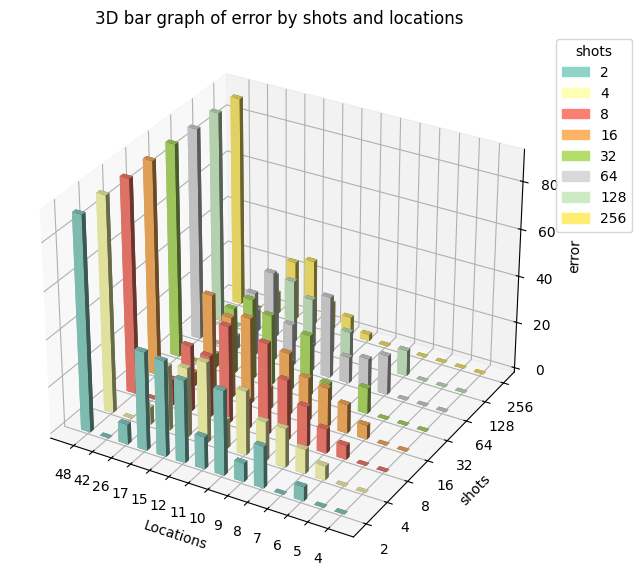

(None,)

In [432]:
input = 'error'
plot_3d_graph_models(shots_mean_ml, input, input2='shots'), 

In [433]:
shots_summary_ml = df.groupby(['shots',]).mean().reset_index()
shots_summary_ml.drop(columns=['locations'], inplace=True)
shots_summary_ml.drop(columns=['error'], inplace=True)
shots_summary_ml['elapsed'] = shots_summary_ml['elapsed'].astype(int)
shots_summary_ml['iteration_found'] = shots_summary_ml['iteration_found'].round(1)
shots_summary_ml['quality'] = shots_summary_ml['quality'].round(1)
print(shots_summary_ml.to_string(index=False))

 shots  iteration_found  quality  elapsed
     2             71.0     78.8       20
     4             79.3     80.1       42
     8             49.1     78.0       84
    16             41.2     78.6      166
    32             32.2     82.3      331
    64             35.4     80.9      658
   128             41.2     85.0     1346
   256             35.6     87.4     2891


## Impact of models on QML

In [434]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['slice'] == 0.8)]
df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 
         'quality', 'error','mode', ]]

In [435]:
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
680,4,0.8,0,21.0,21.0,1.0,0.0,2
681,5,0.8,0,19.0,19.0,1.0,0.0,2
682,6,0.8,0,241.0,241.0,1.0,0.0,2
683,7,0.8,0,276.2,276.2,1.0,0.0,2
684,8,0.8,1,277.2,277.2,1.0,0.0,2


In [436]:
mode_mean_qml = df.groupby(['locations', 'mode',]).mean().reset_index()
mode_mean_qml.head()


,locations,mode,slice,iteration_found,best_dist_found,best_dist,quality,error
0,4,1,0.8,0.0,21.0,21.0,1.0,0.0
1,4,2,0.8,0.0,21.0,21.0,1.0,0.0
2,5,1,0.8,0.0,19.0,19.0,1.0,0.0
3,5,2,0.8,0.0,19.0,19.0,1.0,0.0
4,6,1,0.8,0.6,241.0,241.0,1.0,0.0


In [437]:
summary_mean_qml = df.groupby([ 'mode',]).mean().reset_index()
summary_mean_qml.head()


,mode,locations,slice,iteration_found,best_dist_found,best_dist,quality,error
0,1,7.243243,0.8,24.378378,207.429730,205.586486,0.993982,0.006018
1,2,8.327273,0.8,51.218182,231.292727,229.474545,0.994212,0.005788


## Impact of optimiser on Classical ML

In [438]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] < 20)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
#df = df[(df['momentum'] == 0.8)]

df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', 'gradient_type']]

In [439]:
df.head()

,locations,iteration_found,quality,error,shots,elapsed,lr,weight_decay,momentum,gradient_type
1153,4,0,100.000000,0.000000,64,36.547650,0.00002,0.0006,0.8,SGD
1154,5,0,100.000000,0.000000,64,58.559934,0.00002,0.0006,0.8,SGD
1155,6,10,100.000000,0.000000,64,79.682216,0.00002,0.0006,0.8,SGD
1156,7,2,89.010638,10.989362,64,107.120503,0.00002,0.0006,0.8,SGD
1157,8,6,82.672237,17.327763,64,135.360423,0.00002,0.0006,0.8,SGD


In [440]:
if SHOW_COUNTS:
    optimiser_mean_ml = df.groupby(['locations', 'lr', 'gradient_type']).count().reset_index()
else:
    optimiser_mean_ml = df.groupby(['locations', 'lr', 'gradient_type']).mean().reset_index()

In [441]:
optimiser_mean_ml.head(100)

,locations,lr,gradient_type,iteration_found,quality,error,shots,elapsed,weight_decay,momentum
0,4,0.00002,Adam,0.0,100.000000,0.000000,64.0,31.572982,0.0006,0.8
1,4,0.00002,SGD,0.0,100.000000,0.000000,64.0,34.055946,0.0006,0.8
2,5,0.00002,Adam,0.0,100.000000,0.000000,64.0,50.558808,0.0006,0.8
3,5,0.00002,SGD,0.0,100.000000,0.000000,64.0,53.356384,0.0006,0.8
4,6,0.00002,Adam,41.0,100.000000,0.000000,64.0,76.153984,0.0006,0.8
5,6,0.00002,SGD,2.4,99.341894,0.658106,64.0,80.784638,0.0006,0.8
6,7,0.00002,Adam,46.0,89.675325,10.324675,64.0,109.742855,0.0006,0.8
7,7,0.00002,SGD,8.0,87.852078,12.147922,64.0,109.794240,0.0006,0.8
8,8,0.00002,Adam,208.0,68.681862,31.318138,64.0,137.314020,0.0006,0.8
9,8,0.00002,SGD,11.6,93.899564,6.100436,64.0,140.054838,0.0006,0.8


In [442]:
optimiser_ml_pivot = optimiser_mean_ml.pivot_table(index='locations', columns='gradient_type', values='quality')
print(optimiser_ml_pivot)

gradient_type        Adam         SGD
locations                            
4              100.000000  100.000000
5              100.000000  100.000000
6              100.000000   99.341894
7               89.675325   87.852078
8               68.681862   93.899564
9               83.854930   81.793257
10              72.859656   71.869287
11              90.357143   88.158912
12              56.480424   70.444694
15              54.089219   67.918715
17              55.988185   71.533312


In [443]:

optimiser_summary_ml = optimiser_mean_ml.pivot_table(index='gradient_type', values='quality')
optimiser_summary_ml.head()

,quality
gradient_type,
Adam,79.271522
SGD,84.801065


### Adam hyperparameter training

In [444]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] == 12)]
df =df[df['gradient_type'] == 'Adam']
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', ]]

In [445]:
if SHOW_COUNTS:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
adam_mean_ml.head()

,lr,weight_decay,locations,iteration_found,quality,error,shots,elapsed,momentum
0,0.00002,0.0000,12.0,79.0,62.859562,37.140438,64.0,312.416320,NaN
1,0.00002,0.0001,12.0,191.0,59.321357,40.678643,64.0,296.820996,NaN
2,0.00002,0.0002,12.0,184.0,58.240252,41.759748,64.0,307.659295,NaN
3,0.00002,0.0006,12.0,39.0,56.480424,43.519576,64.0,270.237657,0.8
4,0.00004,0.0000,12.0,162.0,59.511414,40.488586,64.0,316.319542,NaN


In [446]:
df

,locations,iteration_found,quality,error,shots,elapsed,lr,weight_decay,momentum
1780,12,39,56.480424,43.519576,64,270.237657,0.00002,0.0006,0.8
1846,12,79,62.859562,37.140438,64,312.416320,0.00002,0.0000,NaN
1847,12,162,59.511414,40.488586,64,316.319542,0.00004,0.0000,NaN
1848,12,192,62.793156,37.206844,64,313.483250,0.00008,0.0000,NaN
1849,12,214,67.853881,32.146119,64,314.288378,0.00016,0.0000,NaN
1850,12,157,81.940995,18.059005,64,322.951823,0.00032,0.0000,NaN
1851,12,131,76.578200,23.421800,64,312.484737,0.00064,0.0000,NaN
1852,12,52,74.225775,25.774225,64,300.668934,0.00128,0.0000,NaN
1853,12,33,74.225775,25.774225,64,302.689781,0.00256,0.0000,NaN
1854,12,32,80.498372,19.501628,64,296.571913,0.00512,0.0000,NaN


In [447]:
adam_summary_ml = adam_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='error')
print(adam_summary_ml)

weight_decay     0.0000     0.0001     0.0002     0.0006
lr                                                      
0.00002       37.140438  40.678643  41.759748  43.519576
0.00004       40.488586  39.630305  40.044383        NaN
0.00008       37.206844  39.959596  33.852658        NaN
0.00016       32.146119  17.741486        NaN        NaN
0.00032       18.059005  30.430714        NaN        NaN
0.00064       23.421800  25.774225        NaN        NaN
0.00128       25.774225  20.407069        NaN        NaN
0.00256       25.774225  20.407069        NaN        NaN
0.00512       19.501628  16.399437        NaN        NaN
0.01024       21.396457  18.642209        NaN        NaN


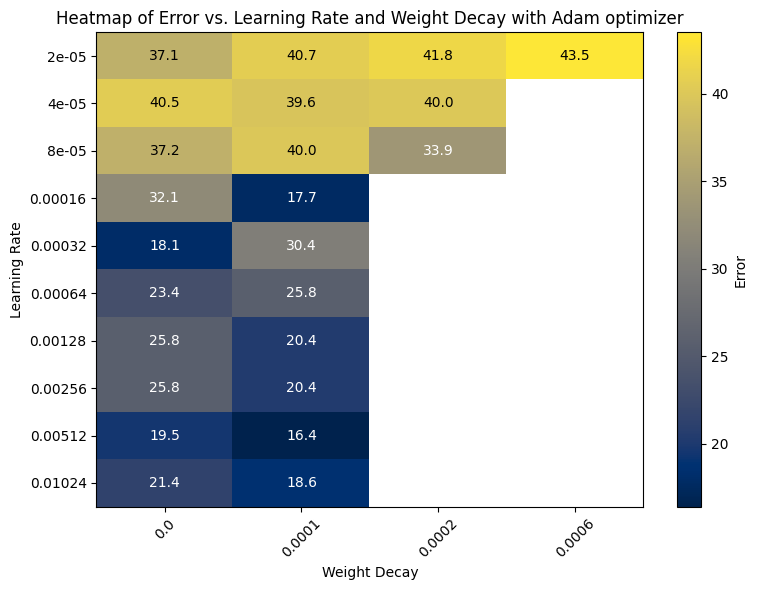

In [448]:
#CMAP_HEATMAP = 'viridis'  # or any other colormap you prefer
#CMAP_HEATMAP = 'cividis'  # or any other colormap you prefer

# Prepare the data
heatmap_data = adam_summary_ml.values
x_labels = adam_summary_ml.columns
y_labels = adam_summary_ml.index

# Create the plot
plt.figure(figsize=(8, 6))
im = plt.imshow(heatmap_data, aspect='auto', cmap=CMAP_HEATMAP)

#im = plt.imshow(heatmap_data, aspect='auto', cmap=CMAP)

# Add colorbar
plt.colorbar(im, label='Error')

# Set axis ticks and labels
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

# Annotate each cell with the numeric value
for i in range(heatmap_data.shape[0]):       # rows
    for j in range(heatmap_data.shape[1]):   # columns
        value = heatmap_data[i, j]
        if not np.isnan(value):  # skip missing values
            if value > 35:
                color = 'black'
            else:
                color = 'white'
            plt.text(j, i, f"{value:.1f}", ha='center', va='center', color=color)

# Add labels and title
plt.xlabel("Weight Decay")
plt.ylabel("Learning Rate")
plt.title("Heatmap of Error vs. Learning Rate and Weight Decay with Adam optimizer")

plt.tight_layout()
plt.show()